# Bayesian Semantic Segmentation


### Introduction

Semantic Segmentation has been a challenging task in computer vision and has seen
limited progress till the advent of neural networks (Badrinarayanan et al., 2015). The goal of
semantic segmentation is to label every pixel of an image with a predefined class and this is
useful for object detection, background elimination and for machine learning tasks downstream.
The issue with neural networks for segmentation however is that they are prone to overfitting,
the predictions are not calibrated effectively, the models are highly sensitive to class imbalances
and to minor changes in data distribution during evaluation. We hope to adopt a full Bayesian
approach to semantic segmentation (Badrinarayanan et al., 2016) to alleviate these concerns
leveraging recent developments in probabilistic programming tools like Edward, techniques like
stochastic BBVI together with neural network as function approximators.

![title](img/example.png)

### Need for Bayesian Approach

####  a) Need for proper output Uncertainity

MLE estimates combined with Softmax class probabilties do not represent true uncertainity and typically are overconfident of the predictions   (e.g. see Figure 1)


![title1](img/crash.jpg)
#### Figure 1.                Tesla  Model S Crash (May 2016) - Perception System confused a white trailer for sky

#### b) Handling Out of train distribution

MLE Estimates perform very poorly if the test distribution differs a lot from training distribution. This raises concerns with how automated system will perform as there is no gurantee that a test sample will be close to training distribution (see Figure 2)


![title1](img/test_distrib.png)
#### Figure 2.                Using a Model trained on UK to test a sample from a different country

#### c) Need for probability calibration

For machine learning systems, output of one model needs to be fed to another model. This requires proper calibration of estimates together with associated uncertainity


## 0. DATA

The data we have chosen is the popular CamVid dataset (Brostow, Shotton, et al., 2008;
Brostow, Fauqueur, & Cipolla, 2008). The dataset contains still images from video footage
from a driving automobile around Cambridge (UK). We will be using a subset of the dataset
rescaled to 360x480 pixels and labels are semantically labeled with 12 classes (Figure3: Sky, Building,
Pole, Road Marking, Road, Pavement, Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist,
Unlabeled). Due to computational constraints, we rescale the image and labels further to 72x96
pixels. This dataset presents very interesting challenges and relevance to the project because of a)
Lower number of training examples and low resolution b) There is high class imbalance between
categories and low frequency classes are most important for detection tasks (e.g pedestrians
occur 340 times less frequently compared to sky/building) c) There is lot of prior information
structure that can be incorporated in to a Bayesian model

![title1](img/colormap.png)

#### Figure 3 - Output Class 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread
import tensorflow as tf
import tensorflow.contrib.slim as slim
from segnet_utils import unpool_with_argmax, get_label_colors, img_annot_to_rgb
from segnet_utils import visualize_image_annot, bayes_visualize_image_annot
from segnet_utils import plot_uncertainity_from_posterior
%matplotlib inline

/home/aravind/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
train_file = 'CamVid/train.txt'
val_file = 'CamVid/val.txt'
test_file = 'CamVid/test.txt'

In [4]:
IMAGE_HEIGHT = 72
IMAGE_WIDTH = 96
IMAGE_DEPTH = 3
NUM_CLASSES = 12
TRAIN_BATCH_SIZE=32
VAL_BATCH_SIZE=TRAIN_BATCH_SIZE
TEST_BATCH_SIZE = TRAIN_BATCH_SIZE
NUM_ITERS = 2000
NUM_TRAIN = 367
NUM_VAL = 101
NUM_TEST = 233

In [5]:
def load_data(file, train=True, batch_size=10, labels=True):
    def _load_image(filename):
        image_string = tf.read_file(filenames[0])
        image_decoded = tf.image.decode_png(image_string, channels=3)
        image_decoded = tf.image.convert_image_dtype(image_decoded,tf.float32)
        return image_decoded

    def _load_image_with_labels(filenames):
        image_string = tf.read_file(filenames[0])
        image_decoded = tf.image.decode_png(image_string, channels=3)
        image_decoded = tf.image.convert_image_dtype(image_decoded,tf.float32)
        image_decoded = tf.image.resize_images(image_decoded, [IMAGE_HEIGHT, IMAGE_WIDTH])
        annot_string = tf.read_file(filenames[1])
        annot_decoded = tf.image.decode_png(annot_string, channels=1)
        annot_decoded = tf.image.resize_images(annot_decoded, [IMAGE_HEIGHT,IMAGE_WIDTH])
        annot_decoded = tf.squeeze(annot_decoded,axis=2)
        annot_decoded = tf.cast(annot_decoded, tf.int64)
        return image_decoded, annot_decoded

    dataset = tf.data.Dataset.from_tensor_slices(tf.constant([file]))
    dataset =  dataset.flat_map(lambda filename: tf.data.TextLineDataset(filename))
    dataset = dataset.map(lambda line: tf.string_split([line], delimiter=' ').values)
    if labels:
        dataset = dataset.map(_load_image_with_labels)
    else:
        dataset = dataset.map(_load_image)
    if train is True:
        dataset = dataset.shuffle(buffer_size=batch_size*3)
    dataset = dataset.batch(batch_size=batch_size)
    iterator = dataset.make_initializable_iterator()
    return iterator

In [6]:
tf.reset_default_graph()
train_iterator = load_data(train_file, batch_size=TRAIN_BATCH_SIZE)
val_iterator = load_data(val_file, train=False, batch_size=TRAIN_BATCH_SIZE)
test_iterator = load_data(test_file, train=False, batch_size=TRAIN_BATCH_SIZE)

## Probabilistic Approach

## 1. MODEL

Differing from the Dropout VI approach that formulates Dropout layers as a form of Bayesian
approximation (Badrinarayanan et al., 2016), our approach is to cycle through Box’s loop to
develop models that are less prone to overfitting, incorporate prior information, deal with class
imbalance and produce well calibrated predictions and model uncertainty. Inference though
stochastic methods will be interesting as we encounter convergence issues and hyperparameter
tuning. Criticism is the most interesting part of our analysis for a computer vision task as we as
humans can easily judge whether the prediction uncertainties make sense.
The following figure summarizes Box’s loop for our project in a succinct manner

$segment_{ij} \sim Categorical(logits=NN) $

## NN (Mike)

In [8]:
import edward as ed
from edward.models import Categorical, Normal, Empirical, StudentT

In [9]:
inputs = tf.placeholder(tf.float32, [TRAIN_BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH ])
labels = tf.placeholder(tf.int32,[TRAIN_BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH])
is_training = tf.placeholder(tf.bool)

In [10]:
def model(inputs_, is_training):
    conv1_w = StudentT(loc=tf.zeros([3,3,3,64]), scale=tf.ones([3,3,3,64]),df=1.0)
    conv1_b = StudentT(loc=tf.zeros([64]), scale=tf.ones([64]),df=1.0)
    net = tf.nn.conv2d(inputs,conv1_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv1_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    net, arg1 = tf.nn.max_pool_with_argmax(net, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    
    conv2_w = StudentT(loc=tf.zeros([3,3,64,128]), scale=tf.ones([3,3,64,128]),df=1.0)
    conv2_b = StudentT(loc=tf.zeros([128]), scale=tf.ones([128]),df=1.0)
    net = tf.nn.conv2d(net,conv2_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv2_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    net, arg2 = tf.nn.max_pool_with_argmax(net, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    conv3_w = StudentT(loc=tf.zeros([3,3,128,256]), scale=tf.ones([3,3,128,256]),df=1.0)
    conv3_b = StudentT(loc=tf.zeros([256]), scale=tf.ones([256]),df=1.0)
    net = tf.nn.conv2d(net,conv3_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv3_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    net, arg3 = tf.nn.max_pool_with_argmax(net, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    net = unpool_with_argmax(net, arg3, name='maxunpool_arg3')
    conv3r_w = StudentT(loc=tf.zeros([3,3,256,128]), scale=tf.ones([3,3,256,128]),df=1.0)
    conv3r_b = StudentT(loc=tf.zeros([128]), scale=tf.ones([128]),df=1.0)
    net = tf.nn.conv2d(net,conv3r_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv3r_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    
    net = unpool_with_argmax(net, arg2, name='maxunpool_arg2')
    conv2r_w = StudentT(loc=tf.zeros([3,3,128,64]), scale=tf.ones([3,3,128,64]),df=1.0)
    conv2r_b = StudentT(loc=tf.zeros([64]), scale=tf.ones([64]),df=1.0)
    net = tf.nn.conv2d(net,conv2r_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv2r_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    
    net = unpool_with_argmax(net, arg1, name='maxunpool_arg1')
    conv1r_w = StudentT(loc=tf.zeros([3,3,64,NUM_CLASSES]), scale=tf.ones([3,3,64,NUM_CLASSES]),df=1.0)
    conv1r_b = StudentT(loc=tf.zeros([NUM_CLASSES]), scale=tf.ones([NUM_CLASSES]),df=1.0)
    net = tf.nn.conv2d(net,conv1r_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv1r_b
    #net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    #net = tf.nn.relu(net)
    
    predicted_mask = Categorical(logits=net)
    
    conv3_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,128,256])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,128,256]))))
    conv3_qb = Normal(loc=tf.Variable(tf.random_normal([256])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([256]))))
    
    conv3r_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,256,128])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,256,128]))))
    conv3r_qb = Normal(loc=tf.Variable(tf.random_normal([128])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([128]))))
    
    conv2_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,64,128])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,64,128]))))
    conv2_qb = Normal(loc=tf.Variable(tf.random_normal([128])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([128]))))

    conv2r_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,128,64])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,128,64]))))
    conv2r_qb = Normal(loc=tf.Variable(tf.random_normal([64])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([64]))))
    
    conv1_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,3,64])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,3,64]))))
    conv1_qb = Normal(loc=tf.Variable(tf.random_normal([64])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([64]))))

    conv1r_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,64,NUM_CLASSES])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,64,NUM_CLASSES]))))
    conv1r_qb = Normal(loc=tf.Variable(tf.random_normal([NUM_CLASSES])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([NUM_CLASSES]))))
    
    
    latent_dict = {conv1_w: conv1_qw, conv1_b: conv1_qb, 
                   conv1r_w:conv1r_qw, conv1r_b: conv1r_qb,
                   conv2_w: conv2_qw, conv2_b: conv2_qb, 
                   conv2r_w:conv2r_qw, conv2r_b: conv2r_qb,
                   conv3_w: conv3_qw, conv3_b: conv3_qb, 
                   conv3r_w:conv3r_qw, conv3r_b: conv3r_qb
                  }
    
    return predicted_mask, latent_dict

predicted_mask, latent_dict = model(inputs, is_training)

## 2. INFERENCE

In [11]:
predicted_mask

<ed.RandomVariable 'Categorical/' shape=(32, 72, 96) dtype=int32>

In [12]:
def inference(predicted_mask, latent_dict, labels, n_epoch=200,session_dir='tmp/inference',restore_sess=False):
    
    N = NUM_TRAIN
    M = TRAIN_BATCH_SIZE
    n_batch=int(N/M)
    loss = []
    if restore_sess:
        sess = ed.get_session()
        saver = tf.train.Saver()
        saver.restore(sess, session_dir)
        return
    else:
        inference = ed.KLqp(latent_dict, data={predicted_mask: labels})
        inference.initialize(n_iter=n_batch*n_epoch, n_samples=5, scale={predicted_mask: N/M})
        saver = tf.train.Saver()
        sess = ed.get_session()
        sess.run(tf.global_variables_initializer())
        sess.run(train_iterator.initializer)
        for i in range(inference.n_iter):
            train_image, train_labels =sess.run(train_iterator.get_next())
            if len(train_image) < TRAIN_BATCH_SIZE:
                sess.run(train_iterator.initializer)
                train_image, train_labels =sess.run(train_iterator.get_next())
            info_dict = inference.update({inputs: train_image, labels: train_labels, is_training: True})
            inference.print_progress(info_dict)
            loss.append(info_dict['loss'])
        saver.save(sess, session_dir)
        loss = np.array(loss)
        plt.plot(loss[10:])

In [13]:
latent_dict

{<ed.RandomVariable 'StudentT/' shape=(3, 3, 3, 64) dtype=float32>: <ed.RandomVariable 'Normal_8/' shape=(3, 3, 3, 64) dtype=float32>,
 <ed.RandomVariable 'StudentT_1/' shape=(64,) dtype=float32>: <ed.RandomVariable 'Normal_9/' shape=(64,) dtype=float32>,
 <ed.RandomVariable 'StudentT_10/' shape=(3, 3, 64, 12) dtype=float32>: <ed.RandomVariable 'Normal_10/' shape=(3, 3, 64, 12) dtype=float32>,
 <ed.RandomVariable 'StudentT_11/' shape=(12,) dtype=float32>: <ed.RandomVariable 'Normal_11/' shape=(12,) dtype=float32>,
 <ed.RandomVariable 'StudentT_2/' shape=(3, 3, 64, 128) dtype=float32>: <ed.RandomVariable 'Normal_4/' shape=(3, 3, 64, 128) dtype=float32>,
 <ed.RandomVariable 'StudentT_3/' shape=(128,) dtype=float32>: <ed.RandomVariable 'Normal_5/' shape=(128,) dtype=float32>,
 <ed.RandomVariable 'StudentT_8/' shape=(3, 3, 128, 64) dtype=float32>: <ed.RandomVariable 'Normal_6/' shape=(3, 3, 128, 64) dtype=float32>,
 <ed.RandomVariable 'StudentT_9/' shape=(64,) dtype=float32>: <ed.RandomVar

In [18]:
inference(predicted_mask, latent_dict, labels, session_dir='checkpoints/test_saver_200',restore_sess=True)

INFO:tensorflow:Restoring parameters from checkpoints/test_saver_200


## 3. CRITICISM

In [15]:
def criticism(predicted_mask, latent_dict, data_iterator, num_samples, ppc_nsamples=100,
              plot_one_batch_only = False, plot_random_index_per_batch=False):
    predicted_mask_post = ed.copy(predicted_mask, latent_dict)
    predicted_mask_post_samples = predicted_mask_post.sample(ppc_nsamples)
    sess = ed.get_session()
    sess.run(data_iterator.initializer)
    num_batches = num_samples // TRAIN_BATCH_SIZE
    for i in range(num_batches):
        images, labels = sess.run(data_iterator.get_next())
        ppc=sess.run(predicted_mask_post_samples,
                 feed_dict={inputs: images, predicted_mask: labels, is_training: True})
        
        if plot_random_index_per_batch:
            idx = np.random.choice(TRAIN_BATCH_SIZE,size=1)[0]
            print(idx)
            fig, ax = plt.subplots(1,3,figsize=(10,12))
            for j in range(ppc_nsamples):
                bayes_visualize_image_annot(images[idx], labels[idx],ppc[j,idx],ax, n_samples=ppc_nsamples)
            plot_uncertainity_from_posterior(ppc,idx,ppc_nsamples)
        else:
            for idx in range(TRAIN_BATCH_SIZE):
                fig, ax = plt.subplots(1,3,figsize=(10,12))
                for j in range(ppc_nsamples):
                    bayes_visualize_image_annot(images[idx], labels[idx],ppc[j,idx],ax, n_samples=ppc_nsamples)
                plot_uncertainity_from_posterior(ppc,idx,ppc_nsamples)
        if plot_one_batch_only:
            break

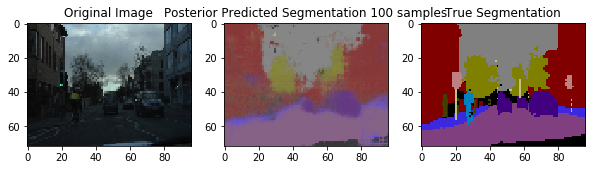

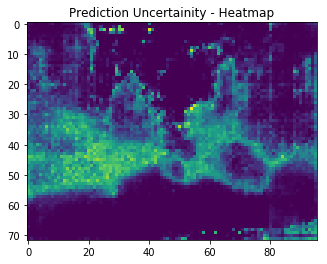

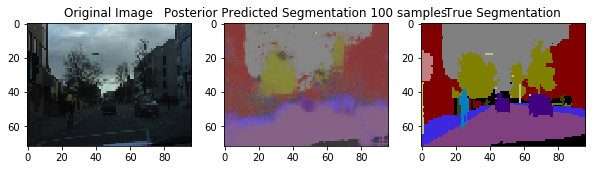

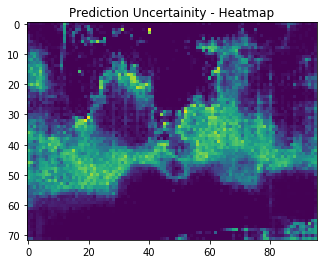

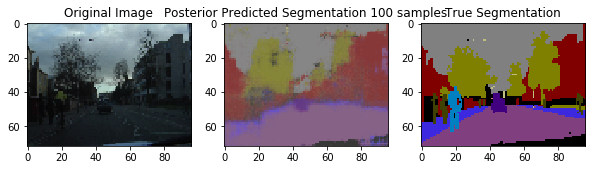

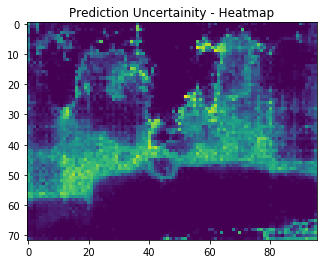

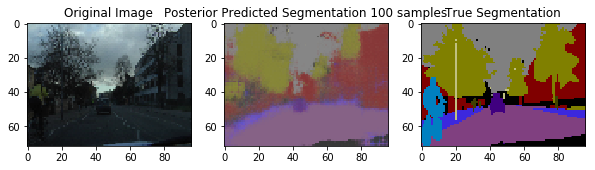

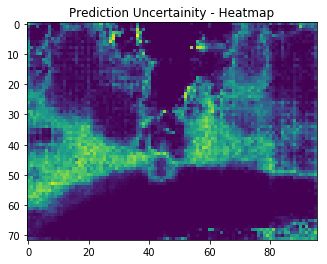

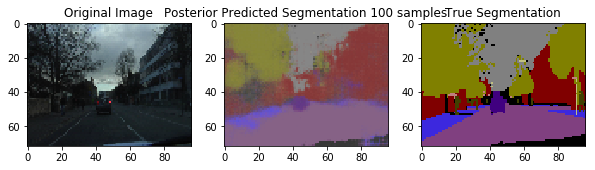

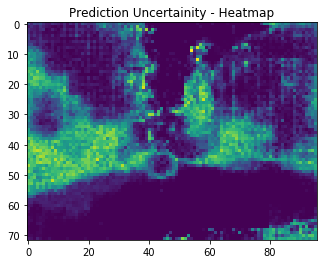

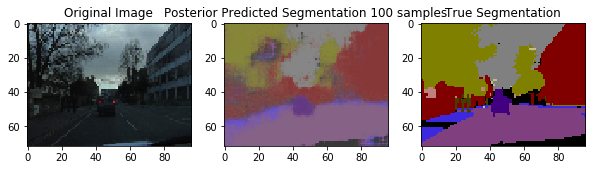

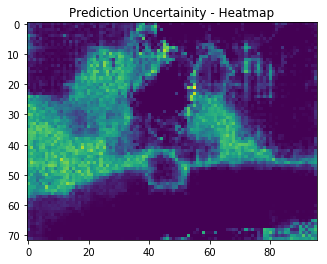

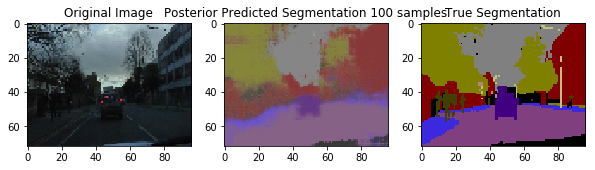

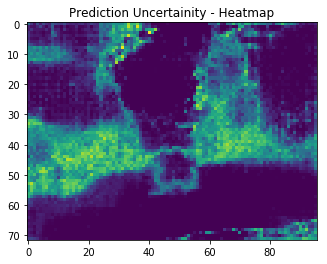

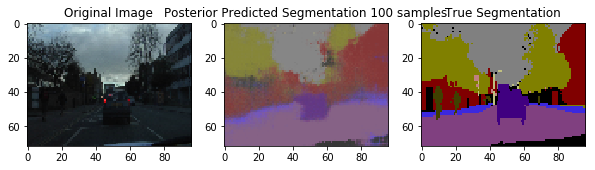

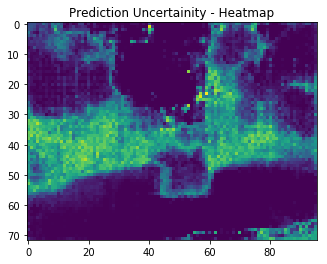

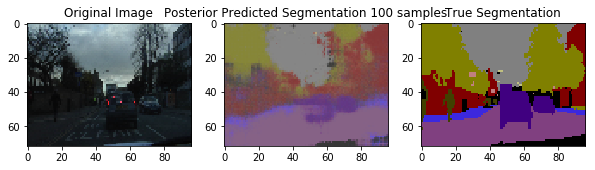

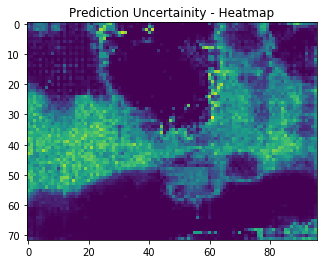

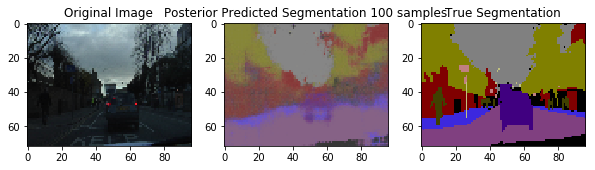

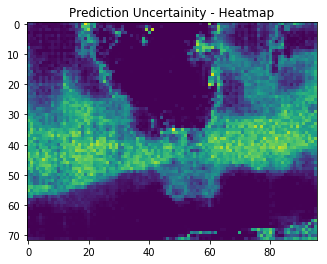

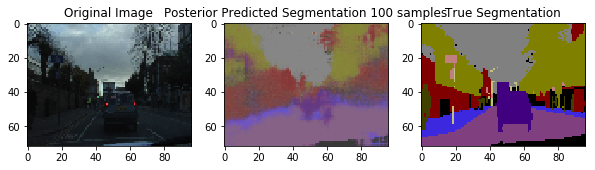

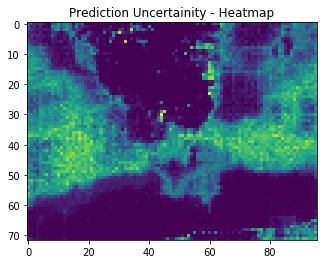

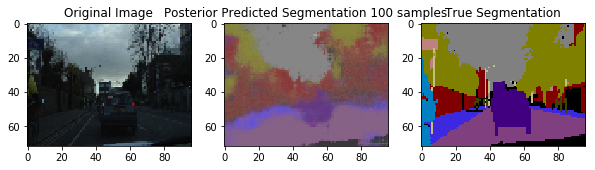

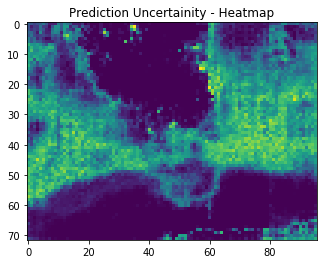

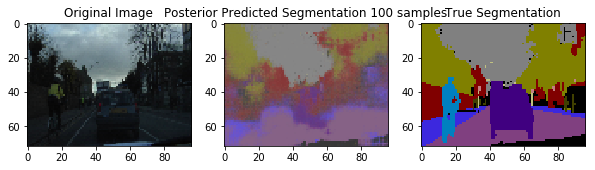

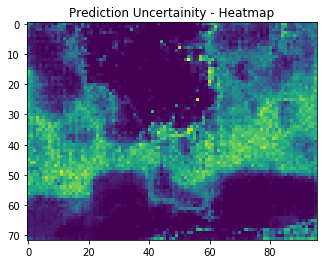

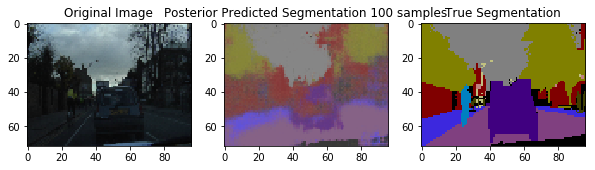

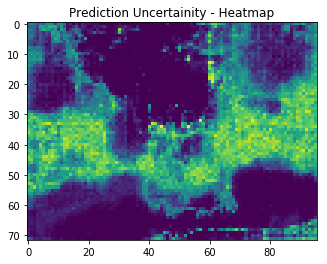

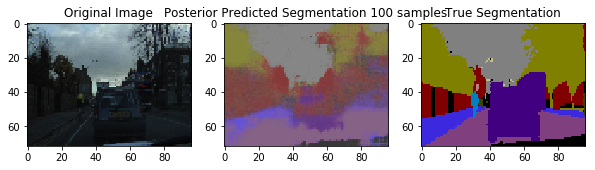

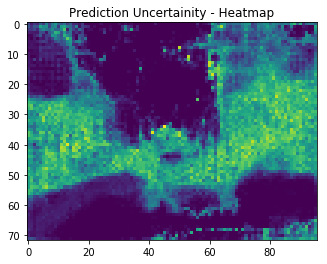

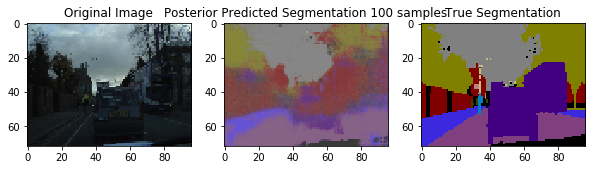

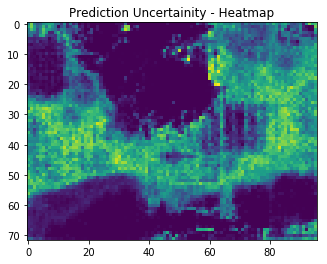

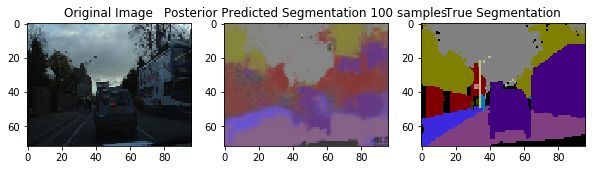

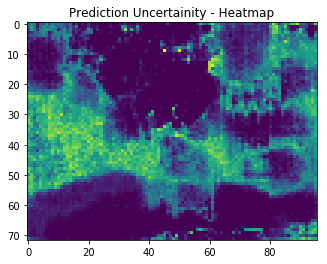

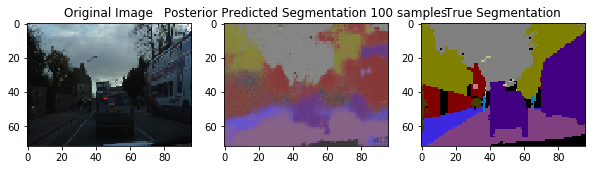

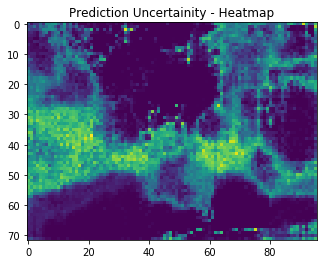

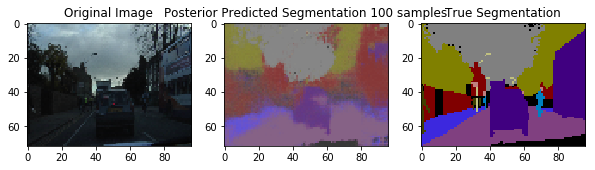

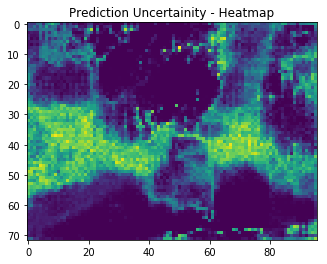

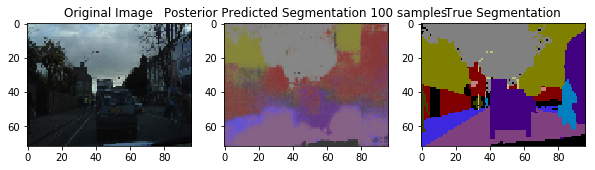

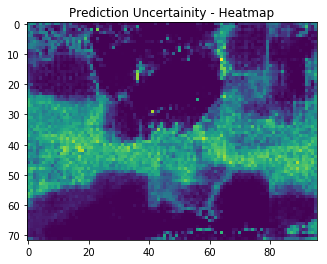

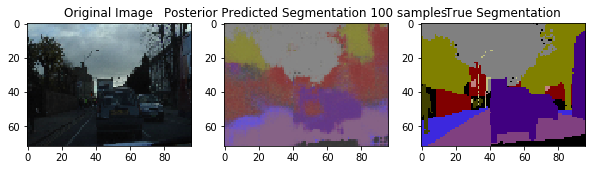

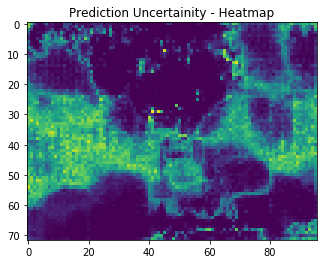

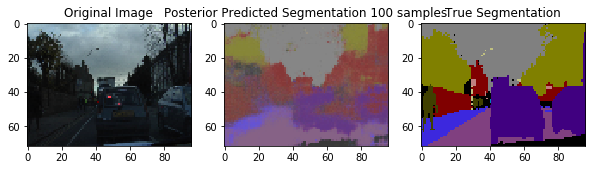

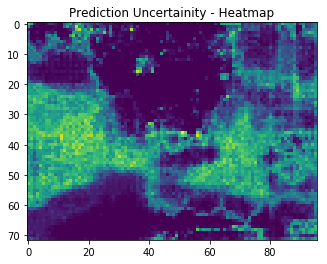

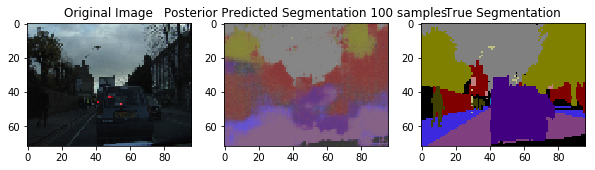

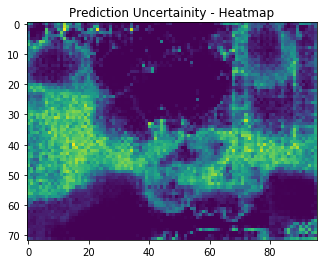

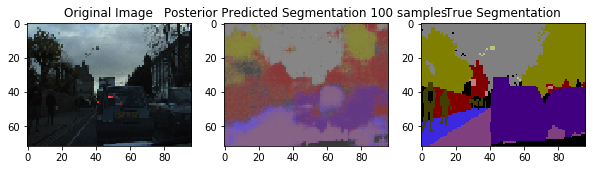

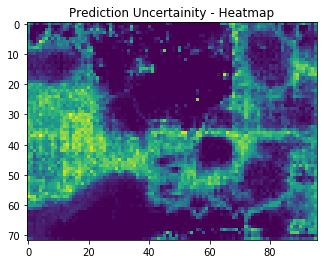

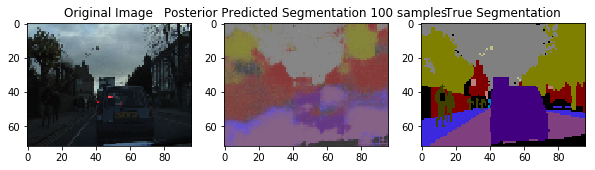

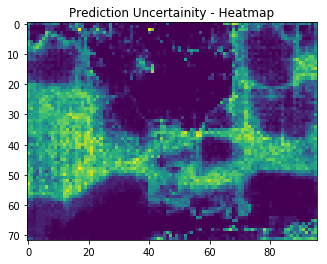

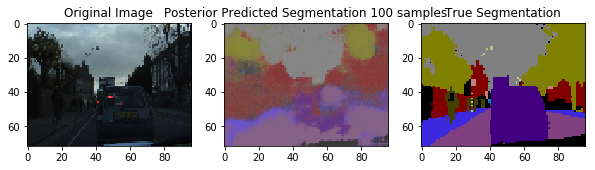

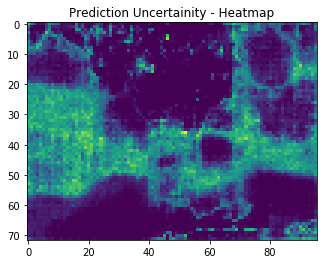

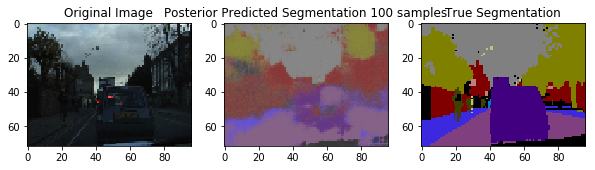

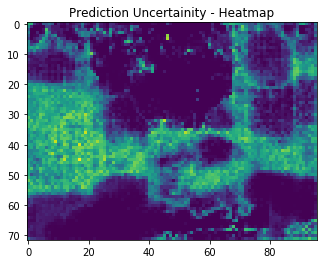

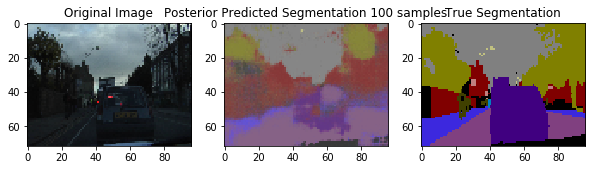

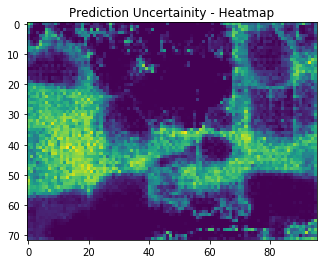

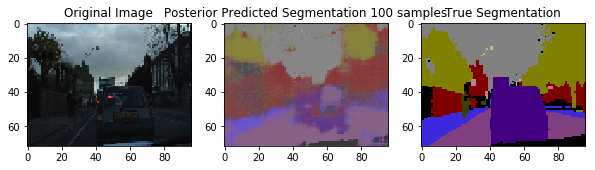

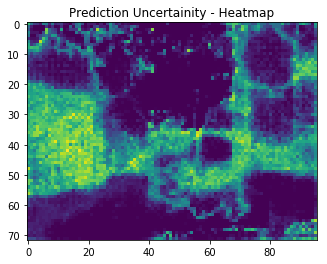

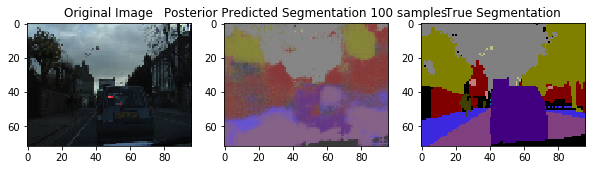

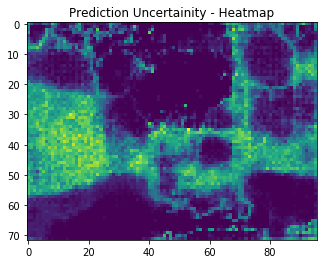

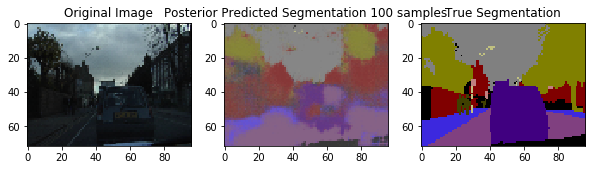

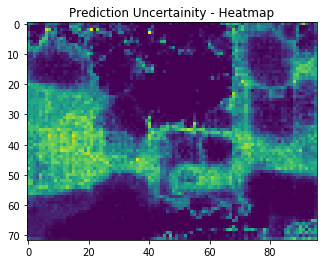

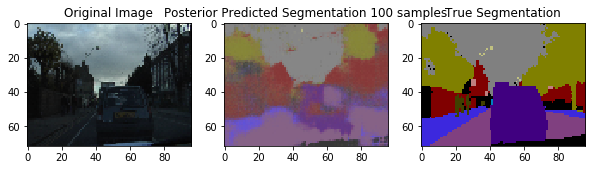

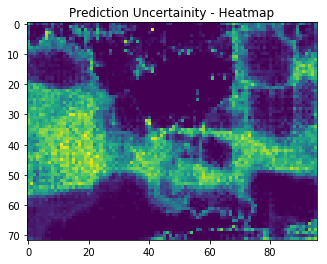

In [16]:
criticism(predicted_mask, latent_dict, test_iterator,NUM_TEST, plot_one_batch_only=True, 
          plot_random_index_per_batch=False)

## 4. REFERENCES

Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). Segnet: A deep convolutional encoder-
decoder architecture for image segmentation. CoRR, abs/1511.00561. Retrieved from
http://arxiv.org/pdf/1511.00561.pdf

Badrinarayanan, V., Kendall, A., & Cipolla, R. (2016). Bayesian segnet: Model uncer-
tainty in deep convolutional encoder-decoder architectures for scene understanding. CoRR,
abs/1511.02680. Retrieved from http://arxiv.org/pdf/1511.02680.pdf

Brostow, G. J., Fauqueur, J., & Cipolla, R. (2008). Semantic object classes in video: A
high-definition ground truth database. Pattern Recognition Letters.

Brostow, G. J., Shotton, J., Fauqueur, J., & Cipolla, R. (2008). Segmentation and recognition
using structure from motion point clouds. In Eccv (1) (p. 44-57).